<a href="https://colab.research.google.com/github/schneider128k/machine_learning_course/blob/master/imdb_movie_reviews_classification_dense_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMBD digits dataset

## Loading the IMBD dataset

The IMDB dataset is a set of 50,000 highly polarized reviews from the Internet Movie Database. The reviews are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.

Just like the MNIST dataset, the IMBD dataset comes packaged with ```tf.keras```. It has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The argument ```num_words=10000``` means we'll only keep the top 10,000 most frequently occuring words in the training data. Rare words will be discarded.  This allows us to work with vector data of manageable size.

The variables ```train_data``` and ```test_data``` are lists of reviews; each review is a list of word indices (encoding a sequence of words).

The variables ```train_labels``` and ```test_labels``` are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive.


In [1]:
%tensorflow_version 2.x
import tensorflow as tf

(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.imdb.load_data(num_words=10000)

TensorFlow 2.x selected.
17465344/17464789 [==============================] - 0s 0us/step


See [https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification) for all more details.

## Preparing the data

As we have seen in the [notebook for loading and exploring the IMDB movie reviews dataset](https://colab.research.google.com/drive/1rYSzV6if2Y4P-X6yrF10IONLynyd416_), the movie reviews are represented as list of integers.  

We can't feed list of integers into a neural network. We have to turn our lists into tensors.  We choose a simple method for doing that and discuss more sophisticated methods such as using the ```Embedding``` layer later.

We one-hot encode our lists to turn them into vectos of 0s and 1s. For instance,turning the sequence ```[0, 1]``` into a 10,000-dimensional vector would produce a vector that would contain all 0s except for indices 3 and 5, which would contain 1s. We can now feed this vector into a ```Dense``` layer, capable of handing floating-point data.



**Code to vectorize the data**

For maximum clarity, let's manually vectorize the data instead of using some build-in functions.

In [0]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.0
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [3]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [4]:
np.sum(x_train[0])

120.0

In [5]:
bag_of_words = set(train_data[0])
len(bag_of_words)

120

## Create validation set

We create a validation set by setting apart 10,000 samples from the original training data to monitor during training the accuracy of the model on data it has never seen before.

In [0]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## Build model

In [0]:
def build_and_compile_model():
    # build model
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(10000,)))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # compile model
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
    return model

## Train model

In [8]:
model = build_and_compile_model()

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 197us/sample - loss: 0.5039 - accuracy: 0.7959 - val_loss: 0.4002 - val_accuracy: 0.8374
Epoch 2/20
15000/15000 [==============================] - 2s 120us/sample - loss: 0.2987 - accuracy: 0.9051 - val_loss: 0.3025 - val_accuracy: 0.8859
Epoch 3/20
15000/15000 [==============================] - 2s 119us/sample - loss: 0.2187 - accuracy: 0.9301 - val_loss: 0.2914 - val_accuracy: 0.8818
Epoch 4/20
15000/15000 [==============================] - 2s 124us/sample - loss: 0.1738 - accuracy: 0.9429 - val_loss: 0.2762 - val_accuracy: 0.8897
Epoch 5/20
15000/15000 [==============================] - 2s 113us/sample - loss: 0.1425 - accuracy: 0.9526 - val_loss: 0.2834 - val_accuracy: 0.8879
Epoch 6/20
15000/15000 [==============================] - 2s 111us/sample - loss: 0.1149 - accuracy: 0.9660 - val_loss: 0.2988 - val_accuracy: 0.8858
Epoch 7/20
15000/15000 [==========================

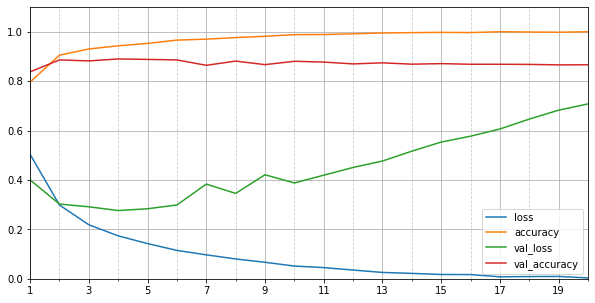

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)


pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.grid(True)

plt.gca().set_ylim(0, 1.1) 
plt.gca().set_xlim(0, 19)

plt.gca().xaxis.set_major_locator(MultipleLocator(2))

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _ : int(x + 1)))

plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().grid(which='minor', color='#CCCCCC', linestyle='--')

plt.show()

We see that the smallest validation loss is achieved at epoch 4.  Training for more epochs leads to overfitting.

## Retrain model 

Let's train a new network from scratch for 4 epochs and then evaluate it on the test data.

In [10]:
model = build_and_compile_model()

model.fit(x_train, y_train, epochs=4, batch_size=512)

Train on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 3s 101us/sample - loss: 0.4825 - accuracy: 0.8202
Epoch 2/4
25000/25000 [==============================] - 2s 81us/sample - loss: 0.2766 - accuracy: 0.9061
Epoch 3/4
25000/25000 [==============================] - 2s 82us/sample - loss: 0.2087 - accuracy: 0.9263
Epoch 4/4
25000/25000 [==============================] - 2s 81us/sample - loss: 0.1726 - accuracy: 0.9402


In [11]:
results = model.evaluate(x_test, y_test)
results

25000/25000 [==============================] - 2s 96us/sample - loss: 0.3068 - accuracy: 0.8788


[0.30676123003005984, 0.87884]

This fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches, we should be able to get close to 95%.

## Code for displaying movie reviews

In [12]:
# word_index is a dictionary mapping words to an integer index
word_index = tf.keras.datasets.imdb.get_word_index()

# reverse it, mapping integer indices to words
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()]
)

def decode_review(data):
    # note that the indices are offset by 3 because
    # 0, 1, and 2 are reserved indices for 
    # "padding", "start of sequence", and "unknown"
    return ' '.join(
        [reverse_word_index.get(i - 3, '?') for i in data]
    )

1646592/1641221 [==============================] - 0s 0us/step


In [0]:
import textwrap

def print_review(data):
    print(textwrap.fill(decode_review(data)))

## Analyze predictions

In [0]:
predictions = model.predict(x_test)

**Wrong predictions**

In [15]:
num = 0
for i in range(25000):
    if np.round(predictions[i][0]) != y_test[i]:
        print('correct sentiment    :', int(y_test[i]))
        print('predicted sentiment  :', int(np.round(predictions[i][0])))
        print('predicted probability:', np.round(predictions[i][0], 2))
        print()
        print_review(test_data[i])
        print('-' * 70)
        print()

        num += 1
        if num == 10:
            break

correct sentiment    : 0
predicted sentiment  : 1
predicted probability: 0.71

? i generally love this type of movie however this time i found myself
wanting to kick the screen since i can't do that i will just complain
about it this was absolutely idiotic the things that happen with the
dead kids are very cool but the alive people are absolute idiots i am
a grown man pretty big and i can defend myself well however i would
not do half the stuff the little girl does in this movie also the
mother in this movie is reckless with her children to the point of
neglect i wish i wasn't so angry about her and her actions because i
would have otherwise enjoyed the flick what a number she was take my
advise and fast forward through everything you see her do until the
end also is anyone else getting sick of watching movies that are
filmed so dark anymore one can hardly see what is being filmed as an
audience we are ? involved with the actions on the screen so then why
the hell can't we have night v

**Correct predictions**

In [16]:
num = 0
for i in range(25000):
    if np.round(predictions[i][0]) == y_test[i]:
        print('correct sentiment    :', int(y_test[i]))
        print('predicted sentiment  :', int(np.round(predictions[i][0])))
        print('predicted probability:', np.round(predictions[i][0], 2))
        print()
        print_review(test_data[i])
        print('-' * 70)
        print()

        num += 1
        if num == 10:
            break

correct sentiment    : 0
predicted sentiment  : 0
predicted probability: 0.15

? please give this one a miss br br ? ? and the rest of the cast
rendered terrible performances the show is flat flat flat br br i
don't know how michael madison could have allowed this one on his
plate he almost seemed to know this wasn't going to work out and his
performance was quite ? so all you madison fans give this a miss
----------------------------------------------------------------------

correct sentiment    : 1
predicted sentiment  : 1
predicted probability: 1.0

? this film requires a lot of patience because it focuses on mood and
character development the plot is very simple and many of the scenes
take place on the same set in frances ? the sandy dennis character
apartment but the film builds to a disturbing climax br br the
characters create an atmosphere ? with sexual tension and
psychological ? it's very interesting that robert altman directed this
considering the style and structure of his